# 导入依赖库及数据

In [22]:
import struct
import random
import numpy as np 
import pandas as pd
import seaborn as sns
import tensorflow as tf
from array import array
from os.path  import join
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import string
from tensorflow.keras.preprocessing.image import array_to_img
import imgaug as ia
import imgaug.augmenters as iaa
from keras.utils.vis_utils import plot_model



In [24]:
# 注意：这里读入的“test”为评估用测试集，训练用测试集请见后文分割出的X_val。
# 读入对应csv中的数据
X_train = pd.read_csv("sign_mnist_train.csv")
X_test = pd.read_csv("sign_mnist_test.csv")

<Axes: xlabel='label', ylabel='count'>

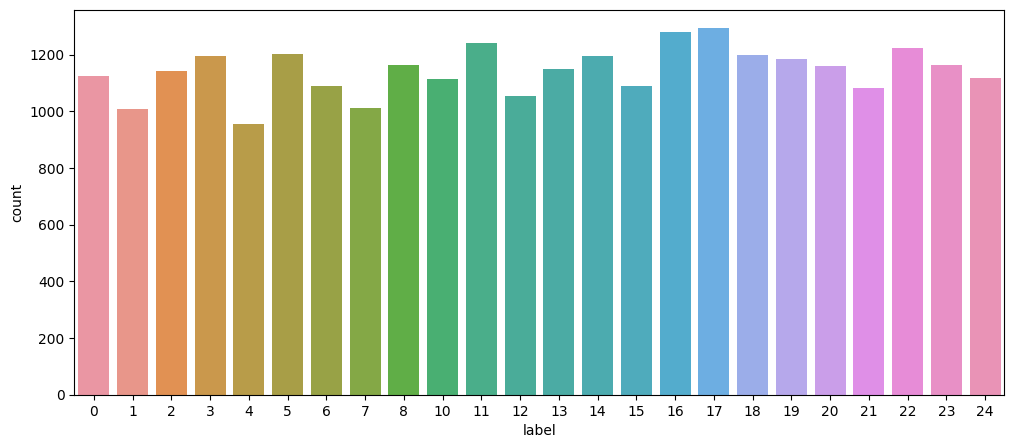

In [25]:
#类图像平衡检测
plt.figure(figsize = (12,5))
sns.countplot(x='label',data=X_train)

In [26]:
# 读取数据集中的标签
y_train = X_train["label"]
y_test = X_test["label"]

# 将标签和数据集分离
X_train.drop(columns = ["label"], inplace = True)
X_test.drop(columns = ["label"], inplace = True)

# 打印、检查数据集和标签的数据类型
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((27455, 784), (7172, 784), (27455,), (7172,))

# 数据集格式转换

In [27]:
# # 数据集图片归一化
# #X_train =X_train.astype(np.float64)/255
# X_train =X_train/255
# X_test = X_test/255


In [28]:
label = y_train.to_numpy()
label[:10]

array([ 3,  6,  2,  2, 13, 16,  8, 22,  3,  3], dtype=int64)

In [29]:
# 将数据集由点集转换为每单位28x28大小的点阵图
X_train = X_train.values.reshape(-1,28,28,1)
X_test = X_test.values.reshape(-1,28,28,1)

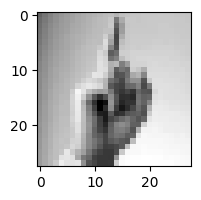

In [30]:
plt.figure(figsize = (2,2))
plt.imshow(X_train[0].reshape(28, 28) , cmap = "gray")

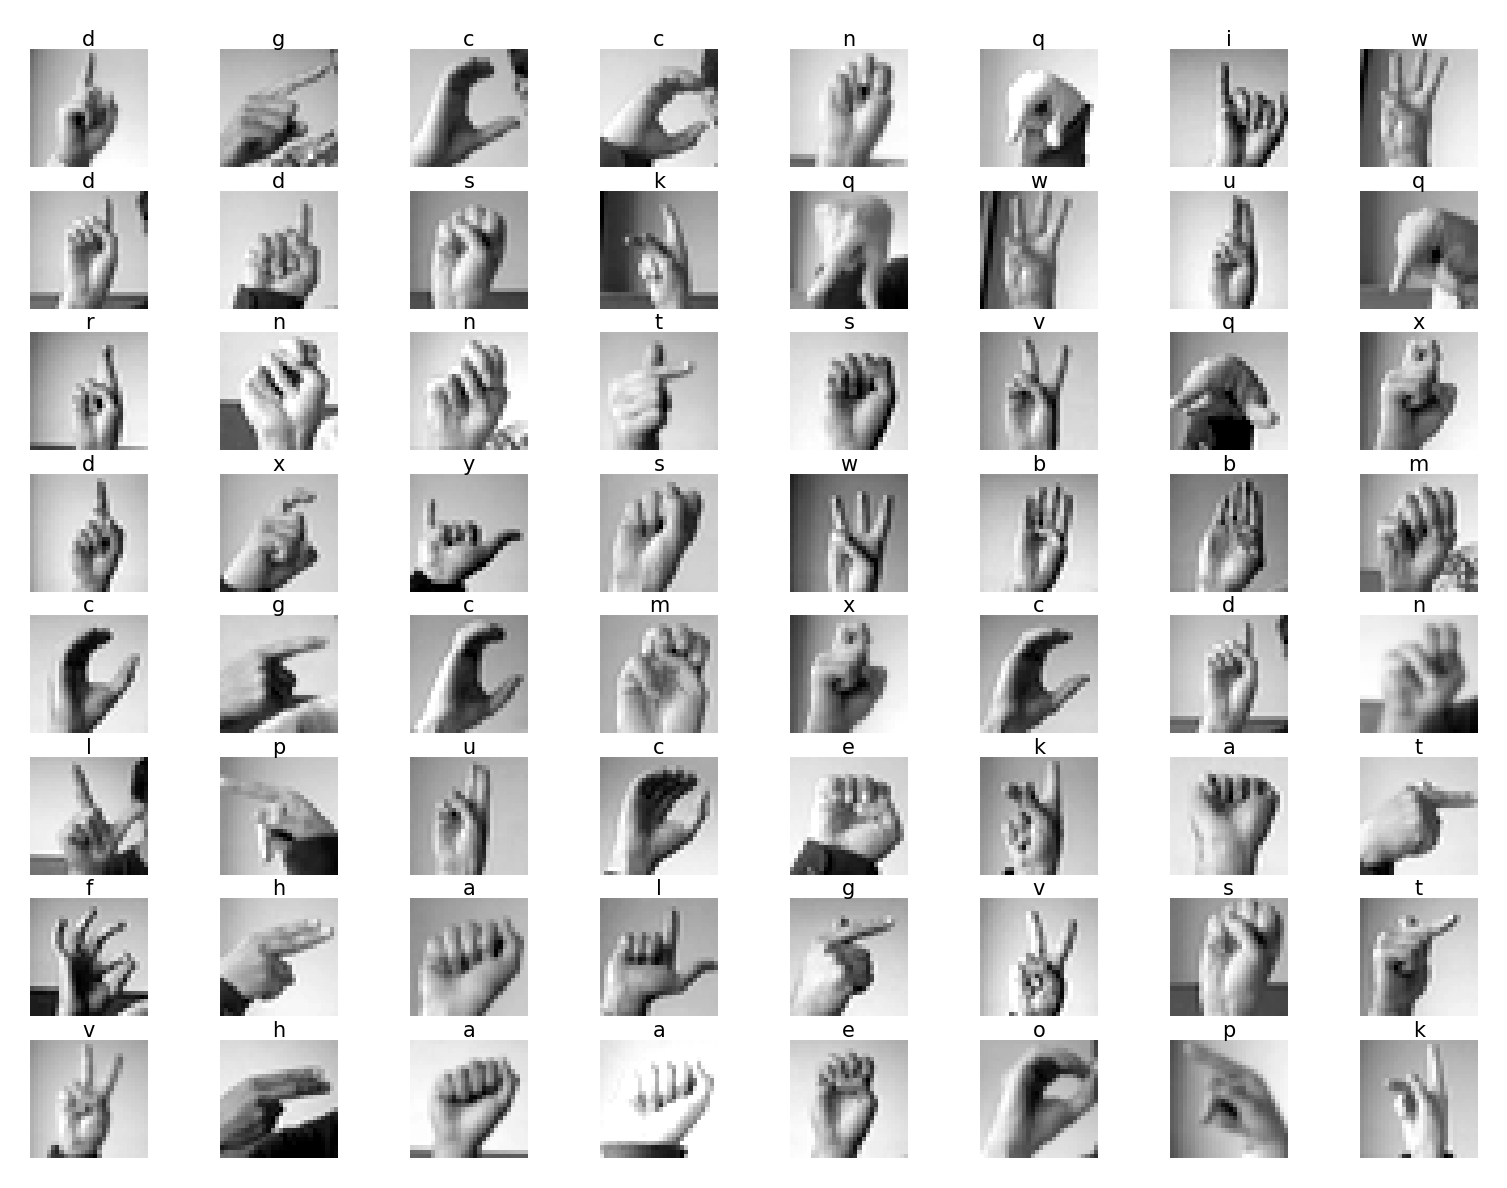

In [31]:
# 检查转型情况
data = X_train.squeeze()
label = y_train.to_numpy()
letters = list(string.ascii_lowercase)
fig = plt.figure(dpi=300)
for i in range(8):
    for j in range(8):
        plt.subplot(8,8, i*8+j+1)
        plt.imshow((data[i*8+j]),cmap='gray')
        plt.title(f"{letters[int(label[i*8+j])]}", fontdict={'size': 5}, pad=1)
        plt.axis('off')
plt.show()

# 数据增强与归一化

In [32]:
# 增强图像数据以防止过度拟合
# 数据增强第一步：定义ImageDataGenerator固定序列、非固定比率随机抽选增强函数
# 后续被调用时才会启用
datagen = ImageDataGenerator(
        featurewise_center=False,  # 将数据集的输入平均值设置为0
        samplewise_center=False,  # 将每个样本的平均值设置为0
        featurewise_std_normalization=False,  # 将输入除以数据集的标准差
        samplewise_std_normalization=False,  # 将每个输入除以其标准差
        zca_whitening=False,  # 应用zca白化
        rotation_range=10,  # 随机旋转范围内的图像，单位度
        zoom_range = 0.1, # 随机缩放图像
        width_shift_range=0.1,  # 随机水平移动图像
        height_shift_range=0.1,  # 随机垂直移动图像
        horizontal_flip=False,  # 随机翻转图像
        vertical_flip=False)  # 随机翻转图像

datagen.fit(X_train)

In [34]:
# 数据集图片归一化
X_train =X_train.astype(np.float64)/255
#X_train =X_train/255
X_test = X_test/255


In [36]:
print(y_train)

0         3
1         6
2         2
3         2
4        13
         ..
27450    13
27451    23
27452    18
27453    17
27454    23
Name: label, Length: 27455, dtype: int64


# 建立、训练CNN模型

In [37]:
#三层卷积，两层全连接。可视化网络结构表见下一个cell。
def getCNNModel(shape):
    
    model = Sequential([
        Conv2D(64, (3,3), strides = 1, padding = "same", input_shape = shape, activation = "relu"),
        BatchNormalization(),
        MaxPool2D((2,2), strides =2, padding = "same"),
        Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        Dropout(0.2),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Conv2D(16 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
        BatchNormalization(),
        MaxPool2D((2,2) , strides = 2 , padding = 'same'),
        Flatten(),
        Dense(512 , activation = 'relu'),
        Dropout(0.3),
        Dense(units = 25 , activation = 'softmax')
    ])
    
    return model

In [38]:
# 模型编译及结构表显示
model = getCNNModel(X_train[0].shape)
model.compile(optimizer = 'adam' , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 batch_normalization_3 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_4 (Batc  (None, 14, 14, 32)      

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


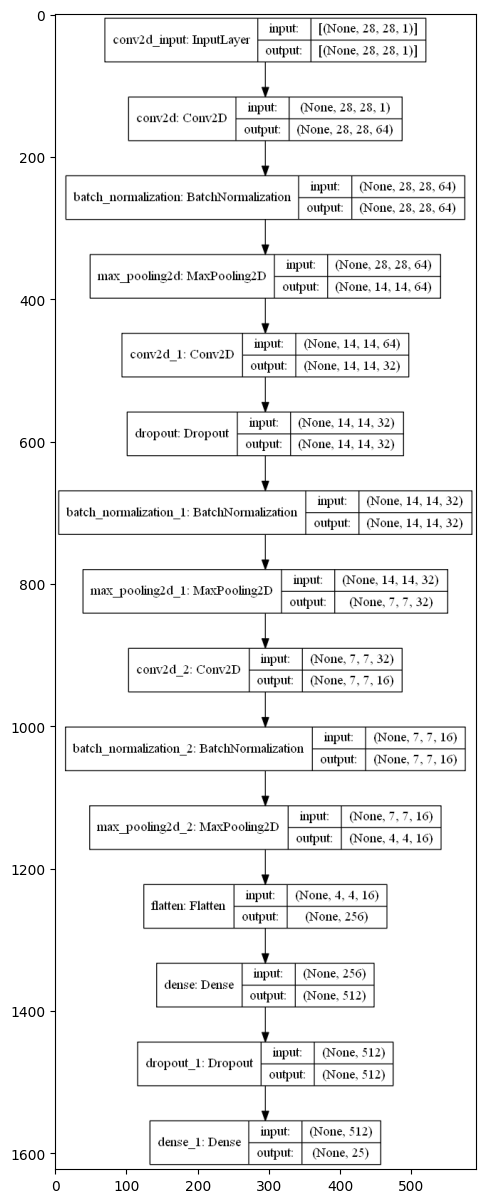

In [39]:
# 模型结构可视化
from keras.utils.vis_utils import plot_model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

#由于系统环境的影响，相关包pydot和graphviz无法被成功引用，上述代码生成的图片已保存在本地，暂时先用plt输出
pic_model = plt.imread('./model.png')
plt.figure(figsize = (15,15))
plt.imshow(pic_model)

In [40]:
# 自适应学习率回调函数定义。
# 参数值定义：监测参考标准=训练用测试集损失值、等待轮次阈值=2、显示自适应调整=True(=1)、每次下降倍率=0.5（倍）、最小学习率=1e-5。
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [41]:
# 分割训练用训练集和测试集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [42]:
# 模型训练。
# 部分参数值定义：
# 入参：对入参为X_train(图片）和y_train（标签）的datagen函数进行bs=128固定大小的顺序序列读取并随机增强
# 训练bs=128、轮次=20、测试数据为分割出的训练用测试集（X_val,y_val）、回调所接入的函数为learning_rate_reduction自适应学习率函数
history = model.fit(datagen.flow(X_train,y_train, batch_size = 128) ,batch_size = 128, epochs = 20 , validation_data = (X_val, y_val) , 
                     callbacks = [learning_rate_reduction])

Epoch 1/20
172/172 [==============================] - 31s 172ms/step - loss: 1.3747 - accuracy: 0.5724 - val_loss: 3.5997 - val_accuracy: 0.0820 - lr: 0.0010
Epoch 2/20
172/172 [==============================] - 27s 159ms/step - loss: 0.3598 - accuracy: 0.8811 - val_loss: 2.2669 - val_accuracy: 0.3034 - lr: 0.0010
Epoch 3/20
172/172 [==============================] - 29s 171ms/step - loss: 0.1871 - accuracy: 0.9388 - val_loss: 0.3804 - val_accuracy: 0.8876 - lr: 0.0010
Epoch 4/20
172/172 [==============================] - 29s 168ms/step - loss: 0.1267 - accuracy: 0.9588 - val_loss: 0.0522 - val_accuracy: 0.9924 - lr: 0.0010
Epoch 5/20
172/172 [==============================] - 30s 176ms/step - loss: 0.0891 - accuracy: 0.9710 - val_loss: 0.0335 - val_accuracy: 0.9911 - lr: 0.0010
Epoch 6/20
172/172 [==============================] - 30s 172ms/step - loss: 0.0708 - accuracy: 0.9778 - val_loss: 0.0158 - val_accuracy: 0.9956 - lr: 0.0010
Epoch 7/20
172/172 [==============================] 

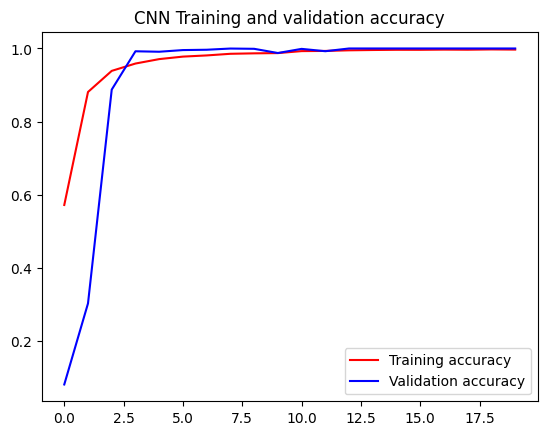

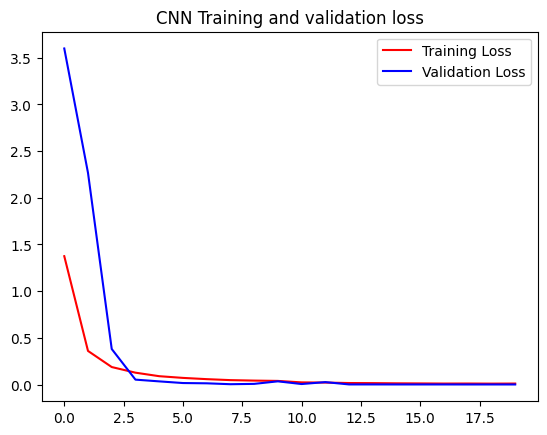

In [43]:
# 获取准确率与损失函数情况
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# matplotlib绘制训练过程中指标的变化状况
epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('CNN Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('CNN Training and validation loss')
plt.legend()

plt.show()

# CNN训练结果定量评估

In [44]:
# 测试用测试集对上述模型进行评估 
print("Test Accuracy " , model.evaluate(X_test,y_test)[1]*100 , "%")

225/225 [==============================] - 2s 9ms/step - loss: 0.0014 - accuracy: 1.0000
Test Accuracy  100.0 %


225/225 [==============================] - 2s 9ms/step


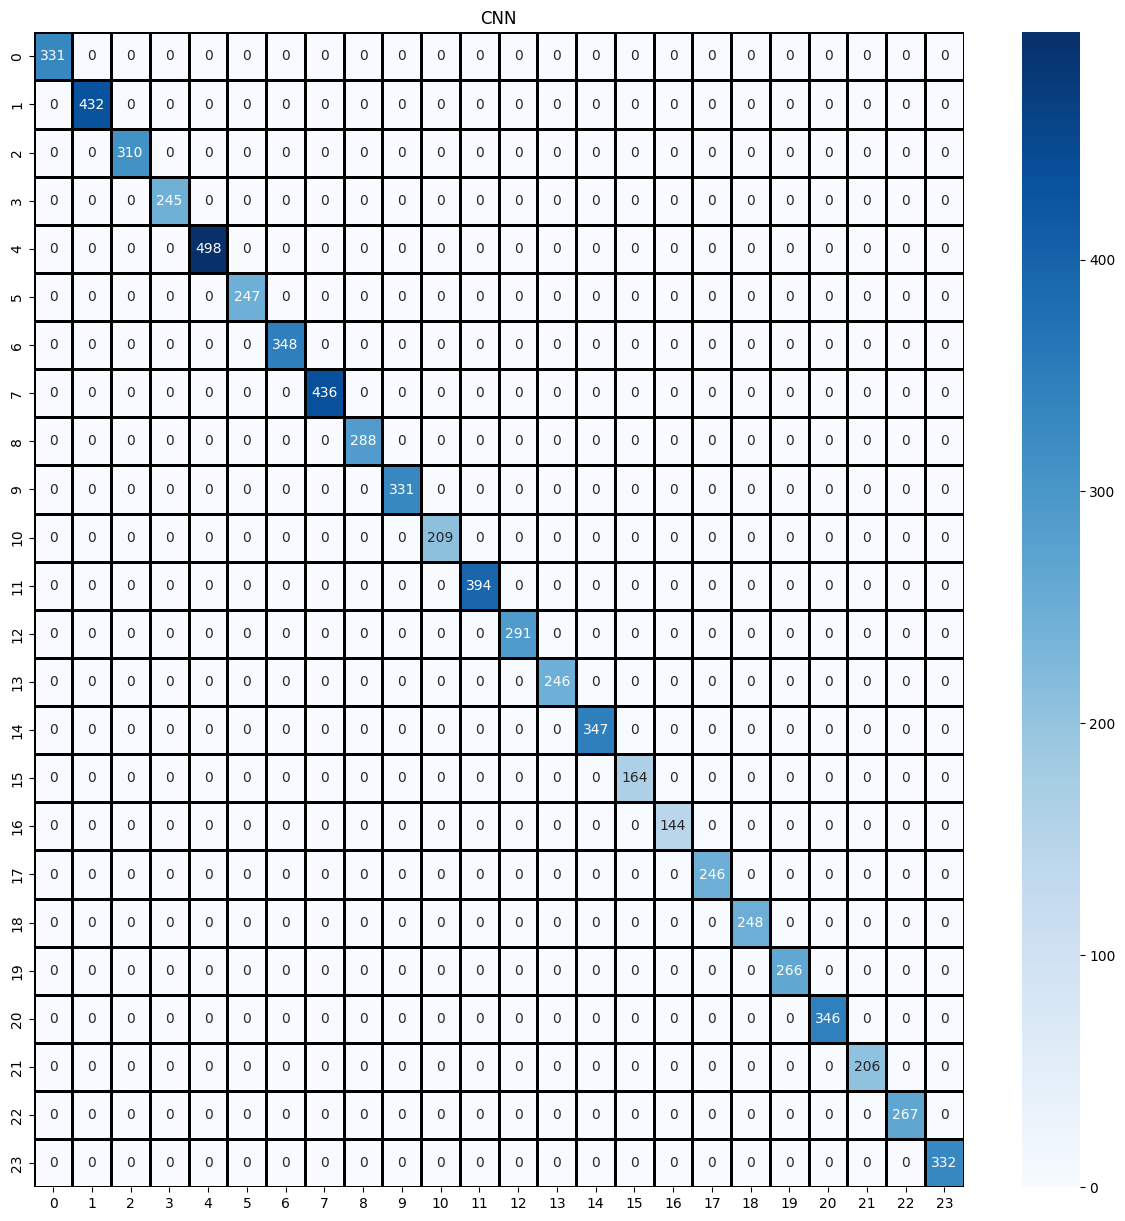

In [45]:
# 混淆矩阵可视化
y_pred=model.predict(X_test) 
classes_y=np.argmax(y_pred,axis=1)
dfConfMat = pd.DataFrame(confusion_matrix(y_test,classes_y))
plt.figure(figsize = (15,15))
plt.title("CNN")
sns.heatmap(dfConfMat,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='');